In [ ]:
# Install libraries
!pip install --pre dgl-cu101

# Import libraries
import torch
from torch import nn
import torch.nn.functional as F

import dgl
import dgl.function as fn
from dgl import DGLGraph

from scipy.special import sph_harm

In [ ]:
from numpy import sqrt
from scipy.special import factorial


def clebsch_gordan(j1,j2,m1,m2,J,M=None):
  ''' Using equations from Wikipedia: https://en.wikipedia.org/wiki/Table_of_Clebsch–Gordan_coefficients '''
  if M is None:
    M=m1+m2
  if M<0:
    return (-1)**(J-j1-j2)*clebsch_gordan(j1,j2,-m1,-m2,J,-M)
  if j1<j2:
    return (-1)**(J-j1-j2)*clebsch_gordan(j2,j1,m2,m1,J,M)
  if not M==m1+m2:
    return 0
  A = sqrt((2*J+1)*factorial(J+j1-j2)*factorial(J-j1+j2)*factorial(j1+j2-J)/factorial(j1+j2+J+1))
  B = sqrt(factorial(J+M)*factorial(J-M)*factorial(j1-m1)*factorial(j1+m1)*factorial(j2-m2)*factorial(j2+m2))
  k_max = min([j1+j2-J,j1-m1,j2+m2])
  k_min = max([0,-(J-j2+m1),-(J-j1-m2)])
  C = 0
  for k in range(int(k_min), int(k_max)+1):
    C += (-1)**k/(factorial(k)*factorial(j1+j2-J-k)*factorial(j1-m1-k)*factorial(j2+m2-k)*factorial(J-j2+m1+k)*factorial(J-j1-m2+k))
  return A*B*C

clebsch_gordan(1/2,1/2,1/2,1/2,1,1)

In [ ]:
# Tensor Field Convolution Layer

# None of this is tested nor expected to work.  It is simply an outline of the
# components of the layer are used together.

# TODO: Finish implementing
# TODO: Make sure the layer feeds through
# TODO: Test for equivariance - test cases
# TODO: Test efficiency against other implements.

class ConvLayer(nn.Module):
  '''Equation 3 in Tensor Field Network paper'''
  def __init__(self, c, li, lf, lo):
    super(ConvLayer, self).__init__()
    self.c = c
    self.li = li
    self.lf = lf
    self.lo = lo

    self.cg = torch.zeros((2*self.li+1,2*self.lo+1))
    for i,m1 in enumerate(np.arange(-j1,j1+1)):
      for j,m2 in enumerate(-np.arange(-j2,j2+1)):
        cb[i,j] = clebsch_gordan(j1,j2,m1,m2,J)


    self.radial = nn.Sequential(nn.Linear(1,5), nn.ReLU(), nn.Linear(5,self.c))

  def _inner_sum_(self, r_vec, V):
    '''Does the sum over b in S'''
    # For a given a so the layer scales with edges, not points squared
    # r_vec:  [BxX]
    # V:      [BxCxLi]
    #
    # r:      [B]
    # R:      [BxC]
    # r_hat:  [BxX]
    # m:      [Lf]
    # Y:      [BxLf]
    # 
    # Li and Lf will be called i and f in einsum respectively

    r = torch.sqrt(torch.sum(r_vec**2,axis=1))
    R = self.radial(r[None,:])[0]

    m = -torch.arange(-self.l, self.l+1) # Backward so diag works!
    theta = torch.arctan2(r_vec[0],r_vec[1])
    phi = torch.arccos(r_hat[2])
    Y = sph_harm(m, self.lf, theta, phi)

    return torch.einsum('bc,bf,bci->cfi',R,Y,V)

  def forward(self, a, g):
    for a in g.nodes:
      r_vec = r[a] - r[:] # How to get connected nodes?
      V_select = V[a]
      sum[a] = self._inner_sum_(r_vec, V_select)
    prod = self.cg[None,None,:,:] * sum[:,:,:,:]
    L = torch.zeros((2*self.lo+1))
    for i, mo in enumerate(torch.arange(-self.lo,self.lo+1)):
      L[i] = torch.sum(torch.diag(prod, diag=mo, axes=(2,3)))
    return L



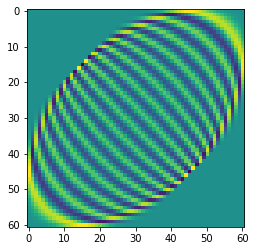

In [ ]:
j1=30
j2=30
J=30
cb = np.zeros((2*j1+1,2*j2+1))
for i,m1 in enumerate(np.arange(-j1,j1+1)):
  for j,m2 in enumerate(np.arange(-j2,j2+1)):
    cb[i,j] = clebsch_gordan(j1,j2,m1,m2,J)

cb*cb
import matplotlib.pyplot as plt
plt.imshow(cb)
plt.show()